# Prototipo

In [1]:
# ── 1) Instalación (solo primera vez en Colab) ──────────────────────────────────
!pip -q install yfinance


In [13]:
# ── 2) Importaciones ────────────────────────────────────────────────────────────
import yfinance as yf
import pandas as pd
from IPython.display import display
# ── Gráficas de series de tiempo (niveles y normalizadas) ───────────────────────
import matplotlib.pyplot as plt

In [8]:
# ── 3) Define aquí tus tickers ─────────────────────────────────────────────────
# Ejemplos (puedes mezclar USA y México .MX). Cambia/añade los que quieras.
tickers = ["AAPL", "MSFT", "TSLA"]  # Para BMV usa p. ej. "AMXL.MX", "WALMEX.MX"


In [7]:
# ── 4) Función para descargar y unir datos ─────────────────────────────────────
def descargar_tickers(tickers, period="5y", interval="1d", auto_adjust=True):
    """
    Descarga datos de Yahoo Finance para 1+ tickers y devuelve un DataFrame 'long'
    con columnas: Ticker, Date, OHLCV (y Adj Close si aplica).
    Maneja automáticamente columnas MultiIndex en cualquier orden.
    """
    import yfinance as yf
    import pandas as pd

    # Acepta lista o cadena ("AAPL MSFT" o "AAPL,MSFT")
    if isinstance(tickers, str):
        tickers = [t.strip() for t in tickers.replace(",", " ").split() if t.strip()]

    raw = yf.download(
        tickers=tickers,
        period=period,
        interval=interval,
        auto_adjust=auto_adjust,
        group_by="column",      # más consistente: (campo, ticker) en muchos casos
        threads=True,
        progress=False
    )

    if raw.empty:
        raise RuntimeError("No se obtuvo ningún dato. Revisa los tickers y el período.")

    # Asegurar nombre del índice de fechas
    idx_name = raw.index.name or "Date"
    raw.index.name = idx_name

    # Normalización a formato 'long'
    campos = {"Open", "High", "Low", "Close", "Adj Close", "Volume"}

    if isinstance(raw.columns, pd.MultiIndex):
        # Detectar si el nivel 0 son campos o tickers
        lvl0_vals = set(map(str, raw.columns.get_level_values(0)))
        if campos & lvl0_vals:
            # Columnas como (campo, ticker)
            datos = (raw.stack(level=1)
                         .reset_index()
                         .rename(columns={"level_1": "Ticker", idx_name: "Date"}))
        else:
            # Columnas como (ticker, campo)
            datos = (raw.stack(level=0)
                         .reset_index()
                         .rename(columns={"level_1": "Ticker", idx_name: "Date"}))
    else:
        # Un solo ticker → columnas planas
        datos = raw.reset_index().rename(columns={idx_name: "Date"})
        # Recuperar el ticker (primero de la lista)
        tk0 = tickers[0] if isinstance(tickers, (list, tuple)) else str(tickers)
        datos["Ticker"] = tk0

    # Quitar filas totalmente vacías
    value_cols = [c for c in ["Open", "High", "Low", "Close", "Adj Close", "Volume"] if c in datos.columns]
    datos = datos.dropna(subset=value_cols, how="all")

    # Orden y columnas amigables
    pref = ["Ticker", "Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
    cols = [c for c in pref if c in datos.columns] + [c for c in datos.columns if c not in pref]
    datos = datos[cols].sort_values(["Ticker", "Date"]).reset_index(drop=True)

    return datos


In [9]:
# ── 5) Descarga ────────────────────────────────────────────────────────────────
datos = descargar_tickers(tickers, period="5y", interval="1d", auto_adjust=True)

print(f"Descargadas {datos['Ticker'].nunique()} series, {len(datos):,} filas en total.")
display(datos.head())


Descargadas 3 series, 3,768 filas en total.


/tmp/ipython-input-981636642.py:40: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  datos = (raw.stack(level=1)


Price,Ticker,Date,Open,High,Low,Close,Volume
0,AAPL,2020-11-27,113.475331,114.370905,113.134624,113.494797,46691300
1,AAPL,2020-11-30,113.864728,117.758538,113.708972,115.889511,169410200
2,AAPL,2020-12-01,117.797464,120.192156,116.824012,119.462067,127728200
3,AAPL,2020-12-02,118.780651,120.094817,117.680652,119.812515,89004200
4,AAPL,2020-12-03,120.240813,120.493912,118.965593,119.676216,78967600


In [10]:
# ── 6) Guardar CSV en Colab ────────────────────────────────────────────────────
ruta_csv = "/content/precios_5y.csv"
datos.to_csv(ruta_csv, index=False)
print(f"✅ Archivo guardado: {ruta_csv}")


✅ Archivo guardado: /content/precios_5y.csv


In [11]:
# ── 7) Tabla ancha (Close por fecha x ticker), útil para modelos/plots ─────────
tabla_cierre = datos.pivot(index="Date", columns="Ticker", values="Close")
display(tabla_cierre.tail())

Ticker,AAPL,MSFT,TSLA
Date,,,
2025-11-20,266.250000,478.429993,395.230011
2025-11-21,271.489990,472.119995,391.089996
2025-11-24,275.920013,474.000000,417.779999
2025-11-25,276.970001,476.989990,419.399994
2025-11-26,278.130005,487.489990,424.713593


In [12]:
# ── 8) Resumen rápido por ticker ───────────────────────────────────────────────
resumen = (datos.groupby("Ticker")
                .agg(primer_fecha=("Date", "min"),
                     ultima_fecha=("Date", "max"),
                     n_obs=("Date", "size"))
           )
display(resumen)

,primer_fecha,ultima_fecha,n_obs
Ticker,,,
AAPL,2020-11-27,2025-11-26,1256
MSFT,2020-11-27,2025-11-26,1256
TSLA,2020-11-27,2025-11-26,1256


In [14]:
# Construye la tabla ancha (Close por fecha x ticker) si no existe
if "tabla_cierre" not in globals():
    assert "datos" in globals(), "No encuentro 'datos'. Ejecuta primero la celda de descarga."
    df = datos.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    tabla_cierre = (df.pivot(index="Date", columns="Ticker", values="Close")
                      .sort_index()
                      .dropna(how="all", axis=1))  # quita columnas totalmente vacías


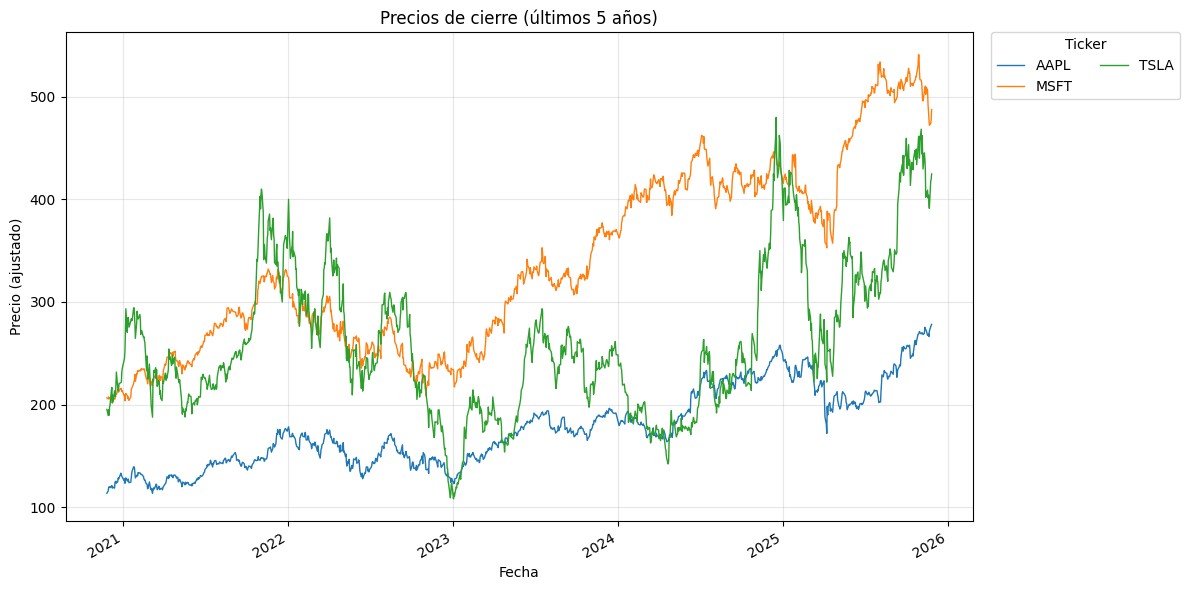

In [15]:
# ── 1) Gráfico en niveles ───────────────────────────────────────────────────────
ax = tabla_cierre.plot(figsize=(12, 6), linewidth=1)
ax.set_title("Precios de cierre (últimos 5 años)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio (ajustado)")
ax.grid(True, alpha=0.3)
ax.legend(title="Ticker", ncol=2, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()


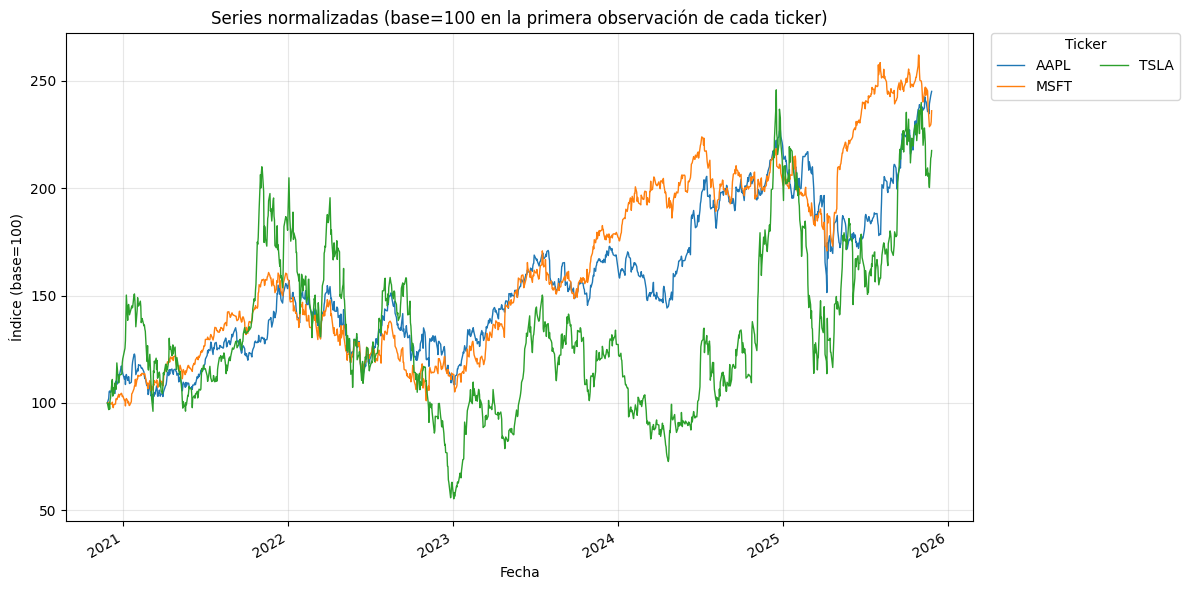

In [16]:
# ── 2) Gráfico normalizado (base=100 en la primera fecha válida de cada serie) ─
norm = tabla_cierre.apply(lambda s: s / s.dropna().iloc[0] * 100, axis=0)

ax = norm.plot(figsize=(12, 6), linewidth=1)
ax.set_title("Series normalizadas (base=100 en la primera observación de cada ticker)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Índice (base=100)")
ax.grid(True, alpha=0.3)
ax.legend(title="Ticker", ncol=2, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()